In [ ]:
#default_exp data.augment

# Data augmentation

> Transforms that have different behavior for different parts of their input

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [ ]:
class MaskItem(ImageItem):
    def __init__(self, **kwargs):
        self.kw = dict(cmap='tab20', alpha=0.5, vmin=1, vmax=30)
class Maskify(Imagify):
    def __init__(self, func=Image.open): self.func,self.assoc = func,MaskItem()

## Transforms

### General arch

In [ ]:
class DataAugTransform(Transform):
    "A transform that randomize its state at each `__call__`"
    is_tuple=True
    def __init__(self, func_name, randomize=None, p=1.): 
        self.func_name,self.p = func_name,p
        if randomize is not None: self.randomize=randomize

    def randomize(self, b): self.state,self.do = {},(random.random() < self.p)
    #Change default mask to be applied on all coords since there is going to be dispatch that defaults to noop
    def _masked(self,b): return zip(b,[True for i in range_of(b)])

    def _apply(self, f, b, filt, **kwargs):
        if not self._filt_match(filt) or not getattr(self, 'do', True): return b
        kwargs = {**getattr(self, 'state', {}), **kwargs}
        if not self.is_tuple: return f(b, self.find_assoc(), **kwargs)
        return tuple(f(o, t, **kwargs) for o,t in zip(b, self.find_assoc()))
    
    def encodes(self, o, t, **kwargs): return getattr(t, self.func_name, noop)(o, **kwargs)
    
    def __call__(self, b, filt=None, **kwargs): 
        self.randomize(b) #Randomize before calling
        return super().__call__(b, filt=filt, **kwargs)

### PIL transforms

In [ ]:
PILFlip = partial(DataAugTransform, func_name='pil_flip', p=0.5)
PILFlip.order = 10

In [ ]:
@patch
def pil_flip(self:ImageItem, o): return o.transpose(PIL.Image.FLIP_LEFT_RIGHT)

In [ ]:
class PILDihedral(DataAugTransform):
    order=10
    def __init__(self, p=0.5): super().__init__('pil_dihedral', p=p)
    def randomize(self, b): 
        self.do = random.random() < self.p
        self.state = {'idx': random.randint(0,7)}

In [ ]:
@patch
def pil_dihedral(self:ImageItem, o, idx=0): return o.transpose(idx-1) if idx>=1 else o

### Affine tfm on the GPU

In [ ]:
class AffineTfm(DataAugTransform):
    "Combine and apply random affine transforms"
    order = 30
    def __init__(self, aff_tfms, size=None, mode='bilinear', pad_mode='reflection'):
        self.aff_tfms,self.mode,self.pad_mode = aff_tfms,mode,pad_mode
        self.size = None if size is None else (size,size) if isinstance(size, int) else tuple(size)
        super().__init__('affine')
    
    def randomize(self, b): 
        self.state = dict(size=self.size,mode=self.mode,pad_mode=self.pad_mode)
        self.state['mat'] = self._get_affine_mat(b[0])[:,:2]
    
    def _get_affine_mat(self, x):
        aff_m = torch.eye(3, dtype=x.dtype, device=x.device)
        aff_m = aff_m.unsqueeze(0).expand(x.size(0), 3, 3)
        ms = [tfm(x) for tfm in self.aff_tfms]
        ms = [m for m in ms if m is not None]
        for m in ms: aff_m = aff_m @ m
        return aff_m

In [ ]:
@patch
def affine(self:ImageItem, x, mat=None, size=None, mode='bilinear', pad_mode='reflection'):
    if mat is None: return x
    bs = x.size(0)
    size = tuple(x.shape[-2:]) if size is None else size
    size = (bs,x.size(1)) + size
    coords = F.affine_grid(mat, size)
    return F.grid_sample(x, coords, mode=mode, padding_mode=pad_mode)

@patch
def affine(self:MaskItem, x, mat=None, size=None, mode='bilinear', pad_mode='reflection'):
    if mat is None: return x
    return ImageItem.affine(self, x.float(), mat=mat, size=size, mode='nearest', pad_mode=pad_mode).long()

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

def affine_mat(*ms):
    "Restructure length-9 vector `ms` into an affine matrix"
    return stack([stack([ms[0], ms[1], ms[2]], dim=1),
                  stack([ms[3], ms[4], ms[5]], dim=1),
                  stack([ms[6], ms[7], ms[8]], dim=1)], dim=1)

def flip_affine(x, p=0.5):
    "Flip as an affine transform"
    mask = -2*x.new_empty(x.size(0)).bernoulli_(p)+1
    return affine_mat(mask,     t0(mask), t0(mask),
                      t0(mask), t1(mask), t0(mask),
                      t0(mask), t0(mask), t1(mask))

In [ ]:
# export
def mask_tensor(x, p=0.5, neutral=0.):
    "Mask elements of `x` with probability `p` by replacing them with `neutral`"
    if p==1.: return x
    if neutral != 0: x.add_(-neutral)
    mask = x.new_empty(*x.size()).bernoulli_(p)
    x.mul_(mask)
    return x.add_(neutral) if neutral != 0 else x

In [ ]:
def flip_dihedral(x, p=0.5):
    idx = mask_tensor(torch.randint(0, 8, (x.size(0),), device=x.device), p=p)
    xs = 1 - 2*(idx & 1)
    ys = 1 - (idx & 2)
    m0,m1 = (idx<4).long(),(idx>3).long()
    return affine_mat(xs*m0,  xs*m1,  t0(xs),
                      ys*m1,  ys*m0,  t0(xs),
                      t0(xs), t0(xs), t1(xs)).float()

## Integration test

### Pets

In [ ]:
source = untar_data(URLs.PETS)/"images"
items = [get_image_files(source)[0]]*100
split_idx = L(range(80)), L(range(80,100))
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')

In [ ]:
tfms = [Imagify(), [labeller, Categorize()]]
ds_img_tfms = [ImageResizer(128), ImageToByteTensor(), PILDihedral()]
dl_tfms = [Cuda(), ByteToFloatTensor()]

In [ ]:
pets = DataSource.build(items, tfms, split_idx, ds_img_tfms)
trn_dl = TfmdDL(pets.train, dl_tfms, 4)

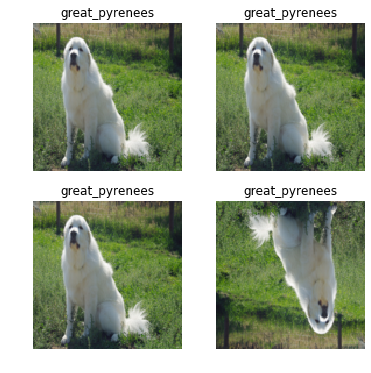

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
tfms = [Imagify(), [labeller, Categorize()]]
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor(), AffineTfm(L(flip_dihedral))]

In [ ]:
pets = DataSource.build(items, tfms, split_idx, ds_img_tfms)
trn_dl = TfmdDL(pets.train, dl_tfms, 4)

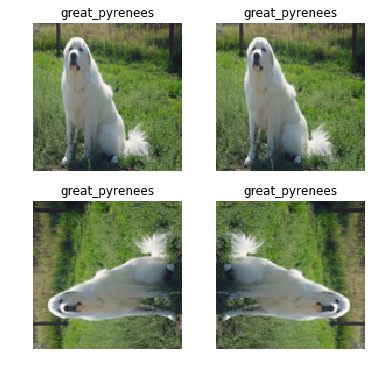

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

### Segmentation

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
ds_img_tfms = [ImageResizer(128), ImageToByteTensor(), PILFlip()]
dl_tfms = [Cuda(), ByteToFloatTensor()]
for t in ds_img_tfms: t.mask = (True,True)
tfms = [[Imagify()],
        [cv_label, Maskify()]]
camvid = DataSource.build(cv_items, tfms, cv_split, ds_img_tfms)
trn_dl = TfmdDL(camvid.train, dl_tfms, 4)

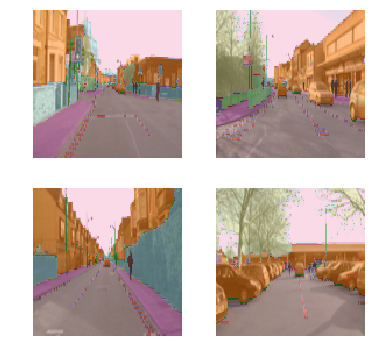

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor(), AffineTfm(L(flip_dihedral))]
for t in ds_img_tfms: t.mask = (True,True)
tfms = [[Imagify()],
        [cv_label, Maskify()]]
camvid = DataSource.build(cv_items, tfms, cv_split, ds_img_tfms)
trn_dl = TfmdDL(camvid.train, dl_tfms, 4)

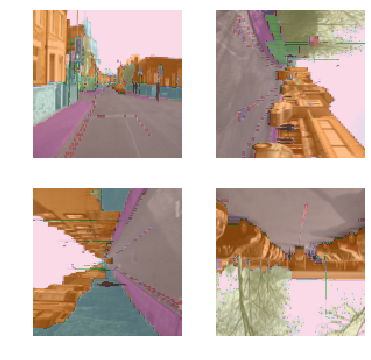

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
# Also adds `p` param (defaults to 1)
AugRotate = make_augment(rotate, degrees=RandFloat(0,90))

NameError: name 'make_augment' is not defined

In [ ]:
# Creates Image.rotate
@patch
def rotate(x:Image, degrees):
    return ...